# This script is used to find all the URLs from the CVE JSON files
# Scanning CVEs for git-based commit URLs

In [158]:
from tabulate import tabulate
from pathlib import Path
import os
import pandas as pd
import glob
import re
import json
import git

def map_rename(columns):
    """Create a renaming mapping dictionary"""
    rename_mapping = {}
    for key in columns.keys():
        rename_mapping[key] = key.split(".")[-1]
    return rename_mapping

def find_json_files(directory):
    """Find all JSON files in the given directory (including subdirectories)."""
    json_files = glob.glob(os.path.join(
        directory, "**/*.json"), recursive=True)
    return json_files

In [157]:



def find_commit_urls(urls):
    """collect all the URLs of they are commit hashes"""
    commit_urls = [url for url in urls if "commit" in url]
    return commit_urls


def find_urls(json_files):
    """collect all the URLs from the CVE Json files"""
    patch_links = {}
    if json_files:
        for json_file in json_files:
            urls = []
            if os.path.isfile(json_file):
                with open(json_file, 'r') as f:
                    urls = re.findall(r'"url": "(.*?)"', f.read())
            if urls:
                patch_links[json_file] = find_commit_urls(urls)
    else:
        print("No JSON file found in the directory.")

    patch_links = {k: v for k, v in patch_links.items() if v}
    return patch_links

if __name__ == "__main__":
    cve_dir = "/Users/guru/research/FixMe/data/cvelistV5/cves"
    json_files = find_json_files(cve_dir)
    print(f"#JSON files: {len(json_files)}")
    patch_links = find_urls(json_files)
    print(f"#URLs: {len(patch_links)}")

#JSON files: 25843
#URLs: 2258


In [13]:

# def json2df(json_file):
#     """Convert JSON data to a pandas DataFrame"""
#     # Read JSON data from file
#     df = pd.DataFrame()
#     with open(json_file, "r") as f:
#         cvedict = json.load(f)
#         data = {}
#         print(cvedict['cveMetadata'])

#         id = cvedict['cveMetadata']['cveId']
#         dataVersion = cvedict['dataVersion'] if  cvedict['dataVersion'] else None
#         state = cvedict['cveMetadata']['state'] if cvedict['cveMetadata']['state'] else None
#         dateReserved = cvedict['cveMetadata']['dateReserved'] if cvedict['cveMetadata']['dateReserved'] else None
#         # datePublished = cvedict['cveMetadata']['datePublished'] if cvedict['cveMetadata']['datePublished'] else None
#         dateUpdated = cvedict['cveMetadata']['dateUpdated'] if cvedict['cveMetadata']['dateUpdated'] else None
#         # dateRejected = cvedict['cveMetadata']['dateRejected'] if cvedict['cveMetadata']['dateRejected'] else None
#         # description = cvedict['containers']['cna']['descriptions'] if cvedict['containers']['cna']['descriptions'] else None
#         if id:
#             data = {
#                 'id': id,
#                 'dataVersion': dataVersion,
#                 'state': state,
#                 "dateReserved": dateReserved,
#                 # "datePublished": datePublished,
#                 "dateUpdated": dateUpdated,

#             }
#     # df = pd.DataFrame(data)
#     return data, cvedict

# cvefile = '/Users/guru/research/FixMe/data/cvelistV5/cves/2024/27xxx/CVE-2024-27319.json'
# cve_json, cvedict = json2df(cvefile)
# cve_json

{'cveId': 'CVE-2024-27319', 'assignerOrgId': '6f8de1f0-f67e-45a6-b68f-98777fdb759c', 'state': 'PUBLISHED', 'assignerShortName': 'HiddenLayer', 'dateReserved': '2024-02-23T16:59:23.010Z', 'datePublished': '2024-02-23T17:39:52.870Z', 'dateUpdated': '2024-02-23T17:39:52.870Z'}


{'id': 'CVE-2024-27319',
 'dataVersion': '5.0',
 'state': 'PUBLISHED',
 'dateReserved': '2024-02-23T16:59:23.010Z',
 'dateUpdated': '2024-02-23T17:39:52.870Z'}

In [140]:
def extract_descriptions(descriptions):
    """Extract the descriptions from the descriptions column"""
    desc = []
    if descriptions:
        desc = [descriptions[i]['value'] for i in range(len(descriptions))]
    return desc

def extract_refs(refs_list):
    """Extract the references from the references column"""
    refs = []
    if refs_list:
        refs = [ref['url'] for ref in refs_list]
    return refs

def extract_cwe(problemTypes):
    """Extract the CWE IDs from the problemTypes column"""
    cwes = [entry["cweId"] for pt in problemTypes for entry in pt.get("descriptions", []) if "cweId" in entry]
    return cwes if cwes else ["unknown"]


def extract_capec(capec):
    """Extract the CAPEC IDs from the capec column"""
    capecs = []
    if isinstance(capec, list):
        capecs = [entry['capecId'] for entry in capec if 'capecId' in entry]
    elif isinstance(capec, dict) and 'capecId' in capec:
        capecs = [capec['capecId']]
    return capecs

def append_cve(df, df_json):
    """Fill the missing columns in the DataFrames"""
    all_cols = list(
        set(list(df.columns) + list(df_json.columns)))
    # insert new columns with None values
    for column in all_cols:
        if column not in list(df.columns):
            df[column] = None
        if column not in list(df_json.columns):
            df_json[column] = None

    df = df.sort_index(axis=1)
    df_json = df_json.sort_index(axis=1)

    df = pd.concat([df, df_json], ignore_index=True, sort=False)
    return df

def extract_metrics(metrics):
    """ Iterate through the list and extract nested items
    """
    df = pd.DataFrame()
    for item in metrics:
        for parent_key, parent_value in item.items():
            if isinstance(parent_value, dict):
                parent_df = pd.DataFrame(parent_value, index=[0])
                parent_df.columns = [f"{parent_key}_{col}" for col in parent_df.columns]
                df = pd.concat([df, parent_df], axis=1)
            else:
                df[parent_key] = parent_value
    return df

def extract_cna(cvedict):
    """Extract the CNA data from the cvedict"""
    df_cna = pd.json_normalize(cvedict['containers']['cna'])
    # Apply transformations conditionally
    transformations = [
        ('references', extract_refs),
        ('descriptions', extract_descriptions),
        ('problemTypes', extract_cwe),
        ('impacts', extract_capec),
    ]

    for col, func in transformations:
        if col in df_cna.columns and df_cna[col].any():
            df_cna[col] = df_cna[col].apply(func)
        else:
            df_cna[col] = None

    # Handle metrics separately
    if 'metrics' in df_cna.columns and df_cna['metrics'].any():
        df_metrics = extract_metrics(df_cna['metrics'][0])
        df_cna = pd.concat([df_cna, df_metrics], axis=1)

    df_cna.columns = df_cna.columns.map(lambda x: x.replace('.', '_'))
    return df_cna


def json2df(json_file):
    """Convert JSON data to a pandas DataFrame"""
    # Read JSON data from file
    # print(f"Processing: {json_file}")
    df_cve = pd.DataFrame()
    if Path(json_file).is_file():
        with open(json_file, "r") as f:
            cvedict = json.load(f)
        df_cna = pd.json_normalize(cvedict['containers']['cna'])
        df_cna = extract_cna(cvedict)
        df_meta = pd.json_normalize(cvedict['cveMetadata'])
        # concatenate these two dataframes
        df_cve = pd.concat([df_meta, df_cna], axis=1)
    else:
        print(f"File not found: {json_file}")
    return pd.DataFrame(df_cve)


def merge_json_files(json_files):
    """Merge all the JSON files into a single DataFrame"""
    print("=" * 20 + "Merging JSON files" + "=" * 20)
    print(f"#JSON files to scan: {len(json_files)}")
    print("=" * 40)
    df = pd.DataFrame()

    for json_file in json_files:
        df_json = json2df(json_file)
        if len(df_cve) > 0 and "cveId" in list(df_json.columns):
            if df.empty:
                df = df_json
            else:
                df = append_cve(df, df_json)

        if len(df) % 500 == 0:
            print(f"#files scanned: {len(df)}")
            print(f"Shape of the data: {df.shape}")
            print("=" * 40)

    df = df.dropna(axis=1, how='all')
    return df

df_all = merge_json_files(list(patch_links.keys()))

print(f'Shape of the data: {df_all.shape}')

====================Merging JSON files====================
#JSON files to scan: 2258
#files scanned: 500
#files scanned: 1000
#files scanned: 1500
#files scanned: 2000
Shape of the data: (2258, 61)


# Trying incremental approach

In [192]:


def clone_or_pull(repo_url, repo_path):
    """Clone the repository if it doesn't exist, or pull if it does."""
    modified_files = []
    print(f"Cloning or pulling {repo_url} to {repo_path}")
    if os.path.exists(repo_path):
        # Repository exists, perform a git pull
        try:
            repo = git.Repo(repo_path)
            origin = repo.remotes.origin
            # Store the current commit before pulling
            current_commit = repo.head.commit
            origin.pull()
            print("Git pull successful")
            # Compare current commit with the latest one after pull
            for item in repo.head.commit.diff(current_commit):
                modified_files.append(item.a_path)
        except git.exc.GitCommandError as e:
            print("Error occurred during git pull:", e)
    else:
        # Repository doesn't exist, perform a git clone
        try:
            git.Repo.clone_from(repo_url, repo_path)
            print("Git clone successful")
        except git.exc.GitCommandError as e:
            print("Error occurred during git clone:", e)
    return modified_files


def get_modified_cve_files(modified_files, data_dir):
    """Find the modified CVE JSON files after a git pull"""
    if modified_files:
        print(f"Modified files after git pull: {modified_files}")
        modified_cve_files = [Path(data_dir, 'cvelistV5', file) for file in modified_files if file.endswith(".json") and "CVE" in file]
        print("Modified files related to CVE:", modified_cve_files)
    else:
        print("No modified files found")
        modified_cve_files = []
    return modified_cve_files


repo_url = "https://github.com/CVEProject/cvelistV5.git"
data_dir = "/Users/guru/research/FixMe/data/"
cve_repo_path = data_dir + Path(repo_url).stem

# Call the clone_or_pull function with the repository URL and path
modified_files = clone_or_pull(repo_url, cve_repo_path)

modified_cve_files = get_modified_cve_files(modified_files, data_dir)
modified_cve_files

Cloning or pulling https://github.com/CVEProject/cvelistV5.git to /Users/guru/research/FixMe/data/cvelistV5
Git pull successful
No modified files found


[]

In [193]:
from pathlib import Path

ref_files = list(patch_links.keys())

if json_files and ref_files:
    print(f"Total JSON files: {len(json_files)}")
    print(f"Total reference files: {len(ref_files)}\n")
    total_cves = [Path(x).stem for x in json_files]
    total_cves = [file for file in total_cves if file.startswith("CVE-")]
    print(f"Total CVEs: {len(total_cves)}")
    ref_cves = [Path(x).stem for x in ref_files]
    ref_cves = [file for file in ref_cves if file.startswith("CVE-")]
    print(f"Total CVEs with references: {len(cves)}")
else:
    print("No JSON file found in the directory.")

Total JSON files: 25843
Total reference files: 2258

Total CVEs: 25843
Total CVEs with references: 2258


# Plotting of original CVEs and FixMe included CVEs counts

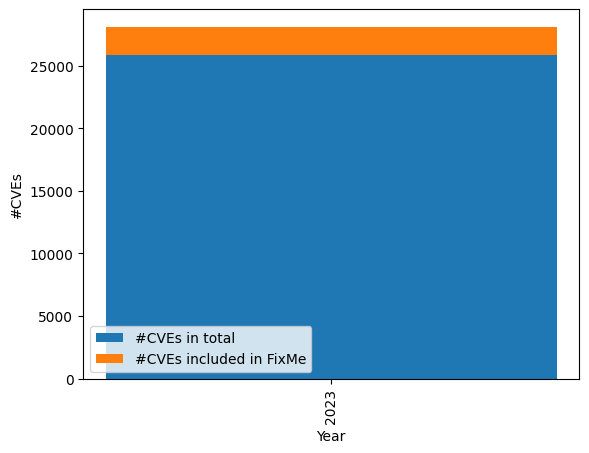

In [194]:
years_cve_total = [file.split('-')[1] for file in total_cves]
years_cve_ref = [file.split('-')[1] for file in ref_cves]

freq_total = pd.Series(years_cve_total).value_counts().sort_index()
freq_ref = pd.Series(years_cve_ref).value_counts().sort_index()

fig, ax = plt.subplots()
bar_width = 0.6
index = range(len(freq_total))

bar1 = ax.bar(index, freq_total, bar_width, label='#CVEs in total')
bar2 = ax.bar(index, freq_ref, bar_width, label='#CVEs included in FixMe', bottom=freq_total.values)

# Adding labels, title, and legend
ax.set_xlabel('Year')
ax.set_ylabel('#CVEs')
ax.set_xticks(index)
ax.set_xticklabels(freq.index, rotation=90)
ax.legend()

plt.show()

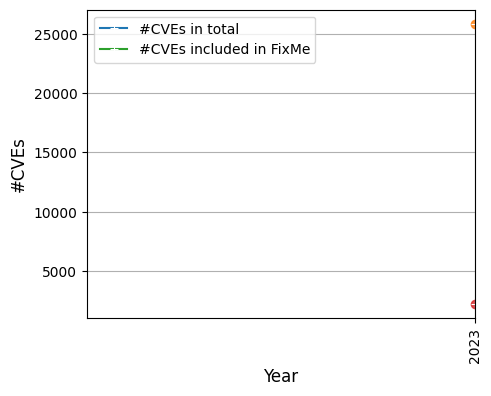

In [170]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

freq_total = pd.Series(years_cve_total).value_counts().sort_index()
df = pd.DataFrame({'year': freq_total.index.astype(int), 'count': freq_total.values.astype(int)})
df['count2'] = freq_ref.values.astype(int)

df.index = df['year']
df.rename(columns={'count': '#CVEs in total', 'count2': '#CVEs included in FixMe'}, inplace=True)

plt.figure(figsize=(5, 4))

for column in df.columns:
    if column != 'year':
        sns.lineplot(x=df.index, y=df[column], marker='+', linestyle='-', label=column)
        # sns.barplot(x=df.index, y=df[column], alpha=0.2, label=column)
        sns.regplot(x=df.index, y=df[column], scatter=True)

plt.xlabel('Year', fontsize=12)
plt.ylabel('#CVEs', fontsize=12)
# plt.title('Trend of CVEs Each Year')
plt.xticks(df.year, rotation=90)  
plt.xlim(1999, 2023)  
plt.grid() 
plt.legend(loc='upper left', fontsize=10)  
plt.show()

# Semantic scholar API to search research papers/datasets

In [ ]:
import requests

api_key = "ATTZX7wvDw8aQ2A3Xmjff8sS0O0UMhqk8Zn3jxCS"


# Define the API endpoint URL
url = 'https://api.semanticscholar.org/graph/v1/paper/search'

# More specific query parameter
query_params = {'query': 'Measurement of Power for DOS attacks', 'limit': 5}

# Define headers with API key
headers = {'x-api-key': api_key}

# Send the API request
response = requests.get(url, params=query_params, headers=headers)

# Check response status
if response.status_code == 200:
   response_data = response.json()
   # Process and print the response data as needed
   print(response_data)
else:
   print(f"Request failed with status code {response.status_code}: {response.text}")
response_data